# Tugas 2

- Silahkan mencari dataset lain. Dari dataset tersebut, ambil 1000 baris saja untuk mempercepat komputasi
- Dengan menggunakan kombinasi antara BOW atau TF-IDF, pasangkan dengan model klasifikasi, seperti MLP, DT, RF, LR, AdaBoost, dll
- Tampilkan hasilnya, dan pilih kombinasi terbaik (feature extraction method + classifier)

sentiment analysis using https://www.kaggle.com/datasets/anggapurnama/twitter-dataset-ppkm dataset from Kaggle and build classification models.

Label: 0 (Positive), 1 (Neutral), 2 (Negative)

In [1]:
%pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-_0nkcnu2
  Running command git clone --filter=blob:none --quiet https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-_0nkcnu2
  Resolved https://github.com/ariaghora/mpstemmer.git to commit 25a5fd923af163a7eac3a5ec976984156ca8fa8b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpstemmer: filename=mpstemmer-0.1.0-py3-none-any.whl size=99801 sha256=341bcff942b19a6552ac31f2834fa4d0a158bc42d6c089c85ee5913d9691371c
  Stored in directory: /tmp/pip-ephem-wheel-cache-s9imrw1k/wheels/85/1f/78/fccc1e7e90613593e0a66304a3711d678e3013034d91534182
Successfully built mpstemmer
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

df = pd.read_csv("data/indoppkmtweet.csv", sep="\t")
df.head()

,Date,User,Tweet,sentiment
0,2022-03-31 14:32:04+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,2022-03-31 09:26:00+00:00,inewsdotid,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,2022-03-31 05:02:34+00:00,vdvc_talk,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,2022-03-30 14:23:10+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,2022-03-30 11:28:57+00:00,tvOneNews,Kementerian Agama menerbitkan Surat Edaran Nom...,1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter
import string
import re
from mpstemmer import MPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv("data/indoppkmtweet.csv", sep="\t")
df.drop(columns=["Date", "User"], inplace=True)
df.head()

,Tweet,sentiment
0,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1


In [5]:
df["Tweet"] = df["Tweet"].str.lower()
df.head()

,Tweet,sentiment
0,ketahui informasi pembagian #ppkm di wilayah j...,1
1,tempat ibadah di wilayah ppkm level 1 boleh be...,1
2,"juru bicara satgas covid-19, wiku adisasmito m...",1
3,ketahui informasi pembagian #ppkm di wilayah j...,1
4,kementerian agama menerbitkan surat edaran nom...,1


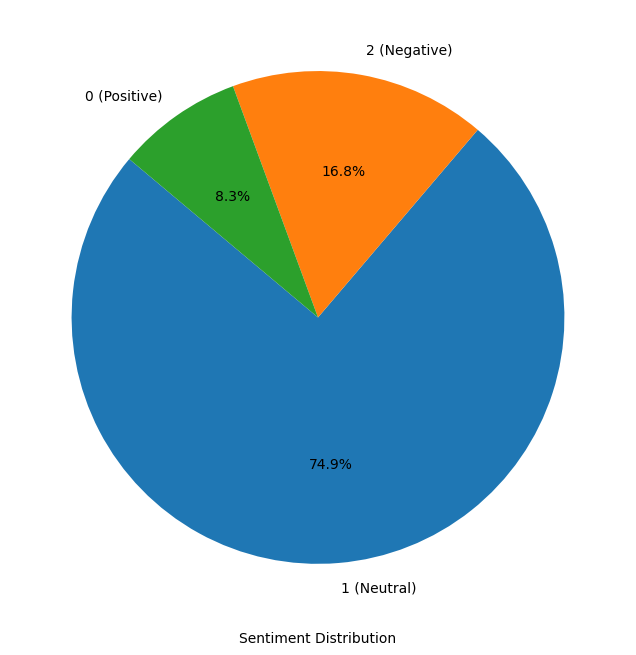

In [12]:
sentiment_counts = df["sentiment"].value_counts()

label_dict = {0: "0 (Positive)", 1: "1 (Neutral)", 2: "2 (Negative)"}

# Buat daftar label sesuai dengan urutan di sentiment_counts
labels = [label_dict[key] for key in sentiment_counts.index]

# pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=labels, autopct="%1.1f%%", startangle=140)
plt.xlabel("Sentiment Distribution")
plt.show()

# Label: 0 (Positive), 1 (Neutral), 2 (Negative)

In [13]:
# fungsi clearning tweet and stemming indonesian words
def remove_hashtags(text):
    tokens = text.split()
    tokens_without_hashtags = [token for token in tokens if not token.startswith("#")]
    return " ".join(tokens_without_hashtags)

def remove_refs(text):
    tokens = text.split()
    tokens_without_hashtags = [token for token in tokens if not token.startswith("@")]
    return " ".join(tokens_without_hashtags)

def remove_links(text):
    tokens = text.split()
    tokens_without_hashtags = [token for token in tokens if not "http" in token]
    return " ".join(tokens_without_hashtags)

def remove_puncs(text):
    for char in string.punctuation:
        text = text.replace(char, "")
    return " ".join(text.split())

def remove_emojis(text):
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoji, '', text)

stemmer = MPStemmer()

contoh = "yuk kakak dibeli #netflix nya, murah kok, cuma 25rb/bulan, bisa nonton 📺 unlimited film dan series, minat? langsung chat aja ya @netflixid https://netflix.com"

print(remove_hashtags(contoh))
print(remove_refs(contoh))
print(remove_links(contoh))
print(remove_puncs(contoh))
print(remove_emojis(contoh))
print(stemmer.stem_kalimat(contoh))

yuk kakak dibeli nya, murah kok, cuma 25rb/bulan, bisa nonton 📺 unlimited film dan series, minat? langsung chat aja ya @netflixid https://netflix.com
yuk kakak dibeli #netflix nya, murah kok, cuma 25rb/bulan, bisa nonton 📺 unlimited film dan series, minat? langsung chat aja ya https://netflix.com
yuk kakak dibeli #netflix nya, murah kok, cuma 25rb/bulan, bisa nonton 📺 unlimited film dan series, minat? langsung chat aja ya @netflixid
yuk kakak dibeli netflix nya murah kok cuma 25rbbulan bisa nonton 📺 unlimited film dan series minat langsung chat aja ya netflixid httpsnetflixcom
yuk kakak dibeli #netflix nya, murah kok, cuma 25rb/bulan, bisa nonton  unlimited film dan series, minat? langsung chat aja ya @netflixid https://netflix.com
ayo kakak beli #netflix nya, murah kok, cuma 25rb/bulan, bisa tonton 📺 unlimited film dan series, minat? langsung chat aja iya @netflixid https://netflix.com
